In [1]:
import json
def read_corpus():
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分需要在 Part 2.3里处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（下标位置一致）
    """
    # TODO 需要完成的代码部分 ...
    qlist = []
    alist = []
    filename = 'train-v2.0.json'
    datas = json.load(open(filename,'r'))
    data = datas['data']
    for d in data:
        paragraph = d['paragraphs']
        for p in paragraph:
            qas = p['qas']
            for qa in qas:
                #print(qa)
                #处理is_impossible为True时answers空
                if(not qa['is_impossible']):
                    qlist.append(qa['question'])
                    alist.append(qa['answers'][0]['text'])
    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, alist
qlist,alist = read_corpus()

In [2]:
'famous?'

'famous?'

In [18]:
import nltk
from nltk.corpus import stopwords
import codecs
import re
import numpy as np

def lowerCase(ori_list):
    return [q.lower() for q in ori_list]
def tokenizer(ori_list):
    #分词时处理标点符号
    SYMBOLS = re.compile('[\s;\"\",.!?\\/\[\]\{\}\(\)-]+')
    new_list = []
    for q in ori_list:
        words = SYMBOLS.split(q.strip())
        new_list.append(' '.join(words))
    return new_list

# nltk中stopwords包含what等，但是在QA问题中，这算关键词，所以不看作关键词    
def removeStopWord(ori_list):
    new_list = []
    restored = ['what','when','which','how','who','where']
    english_stop_words = list(set(stopwords.words('english')))#['what','when','which','how','who','where','a','an','the'] #
    for w in restored:
        english_stop_words.remove(w)
    for q in ori_list:
        sentence = ' '.join([w for w in q.strip().split(' ') if w not in english_stop_words])
        new_list.append(sentence)
    return new_list

def removeLowFrequence(ori_list,vocabulary,thres = 10):
    #根据thres筛选词表，小于thres的词去掉
    new_list = []
    for q in ori_list:
        sentence = ' '.join([w for w in q.strip().split(' ') if vocabulary[w] >= thres])
        new_list.append(sentence)
    return new_list

def replaceDigits(ori_list,replace = '#number'):
    #将数字统一替换为replace,默认#number
    DIGITS = re.compile('\d+')
    new_list = []
    for q in ori_list:
        q = DIGITS.sub(replace,q)
        new_list.append(q)
    return new_list

# 定义处理一个单词的函数: 使用参数来控制是否变换小写及停用词去除；接受的是数组list
def handle_sentence(word_list, isLowCase=True, isStopWord=True, isReplaceDigits=True):
    if isLowCase:
        word_list = lowerCase(word_list)
    word_list = tokenizer(word_list)
    if isStopWord:
        word_list = removeStopWord(word_list)
    if isReplaceDigits:
        word_list = replaceDigits(word_list)
    return word_list

new_qlist = handle_sentence(qlist)

In [63]:
handle_sentence('hello World'.split())

['hello', 'world']

In [19]:
# 此时的new_qlist已经是去掉符号和停用词的了；
new_qlist

['when beyonce start becoming popular',
 'what areas beyonce compete when growing',
 "when beyonce leave destiny's child become solo singer",
 'what city state beyonce grow',
 'which decade beyonce become famous',
 'what r&b group lead singer',
 'what album made worldwide known artist',
 "who managed destiny's child group",
 'when beyoncé rise fame',
 "what role beyoncé destiny's child",
 'what first album beyoncé released solo artist',
 'when beyoncé release dangerously love',
 'how many grammy awards beyoncé win first solo album',
 "what beyoncé's role destiny's child",
 "what name beyoncé's first solo album",
 'second solo album what entertainment venture beyonce explore',
 'which artist beyonce marry',
 'set record grammys how many beyonce win',
 'what movie beyonce receive first golden globe nomination',
 'when beyonce take hiatus career take control management',
 'which album darker tone previous work',
 'what movie portraying etta james beyonce create sasha fierce',
 "when desti

In [20]:
# 首先先来看一下总词数
word_total = list()
for q in new_qlist:
    # 这里的q就是指的每一句话
    for w in q.split(' '):
        # w指的是每一个单词
        word_total.append(w)
        
word_total_unique = set(word_total)
# 输出总单词数
word_total.remove('')
print(len(word_total))
print(len(word_total_unique))

562229
37731


In [21]:
# 统计一下qlist中出现1次，2次，3次... 出现的单词个数， 然后画一个plot. 这里的x轴是单词出现的次数（1，2，3，..)， y轴是单词个数

# step1:先统计词频
# dict_word_count:key：单词，value：词的出现次数
# 不用Counter的话，开始需要进行初始化
dict_word_count = {l:0 for l in word_total}
for value in word_total:
    dict_word_count[value] +=1

# step2：再根据词频统计出现1,2,3...n次的单词的个数
# 需要先把set保存，以此来作为字典的key
word_count_set = sorted(list(set(dict_word_count.values())))
dict_appear_count = {s:0 for s in word_count_set}
for w, v in dict_word_count.items():
    dict_appear_count[v] += 1

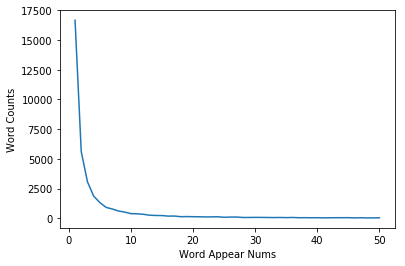

In [22]:
import matplotlib.pyplot as plt
# 绘制出现次数的图，x轴为出现的次数；y轴为出现次数的单词数量；
x_data = list(dict_appear_count.keys())
y_data = list(dict_appear_count.values())
fig = plt.figure()  #设置画布
ax1 = fig.add_subplot(111)
# 看前50个
k = 50
plt.plot(x_data[:k], y_data[:k])
ax1.set_xlabel(u'Word Appear Nums')
ax1.set_ylabel(u'Word Counts')
plt.show()

# 由此图可以看出词库中的一些单词经常使用，而绝大部分单词不常用

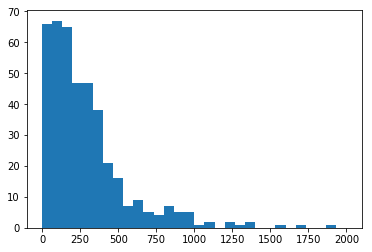

In [23]:
fig = plt.figure()  #设置画布
ax1 = fig.add_subplot(111)
ax1.hist(x_data, range=(0,2000),bins=30)
plt.show()

In [24]:
# 由频率图来对词表进行筛选,把出现次数少且多的词删去，大概为3
def removeLowFrequence(ori_list,vocabulary,thres = 3):
    #根据thres筛选词表，小于thres的词去掉
    new_list = []
    for q in ori_list:
        sentence = ' '.join([w for w in q.strip().split(' ') if vocabulary[w] >= thres])
        new_list.append(sentence)
    return new_list
new_qlist = removeLowFrequence(new_qlist, dict_word_count)

In [25]:
# 二. 文本的表示

In [26]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()  # 定一个tf-idf的vectorizer
X_tfidf = vectorizer.fit_transform(new_qlist)   # 结果存放在X矩阵

Wall time: 713 ms


In [27]:
%%time
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
def loadEmbedding(filename):
    #加载glove模型，转化为word2vec，再加载word2vec模型
    word2vec_temp_file = 'word2vec_temp.txt'
    glove2word2vec(filename,word2vec_temp_file)
    model = KeyedVectors.load_word2vec_format(word2vec_temp_file)
    return model

emb  =  loadEmbedding('glove.6B.200d.txt')# 这是 D*H的矩阵，这里的D是词典库的大小， H是词向量的大小。 
# 这需要从文本中读取来给定的每个单词的词向量
# 用average pooling的方法求算每个句子的句子向量
def computeGloveSentenceEach(sentence,embedding):
    #查找句子中每个词的embedding,将所有embedding进行加和求均值
    emb = np.zeros(200)
    # 将每个句子分成单独的词
    words = sentence.strip().split(' ')
    for w in words:
        if w not in embedding:
            #没有lookup的即为unknown
            w = 'unknown'
        emb += embedding[w]
    return emb / len(words)

def computeGloveSentence(qlist,embedding):
    #对每一个句子进行求均值的embedding
    X_w2v = np.zeros((len(qlist),200))
    for i, q in enumerate(qlist):
        # 这里的q是指的每一个句子
        X_w2v[i] = computeGloveSentenceEach(q,embedding)
    return X_w2v
    
X_w2v =   computeGloveSentence(new_qlist, emb)# 初始化完emb之后就可以对每一个句子来构建句子向量了，这个过程使用average pooling来实现

Wall time: 1min 16s


In [46]:
import heapq
from sklearn.metrics.pairwise import cosine_similarity

def get_least_numbers_big_data(alist, k):
    max_heap = []
    length = len(alist)
    if not alist or k <= 0 or k > length:
        return
    k-=1
    for ele in alist:
        if len(max_heap) <= k:
            heapq.heappush(max_heap, ele)
        else:
            heapq.heappushpop(max_heap, ele)
    return max_heap

In [47]:
def get_top_results_tfidf_noindex(query):
    # TODO 需要编写
    """
    给定用户输入的问题 query, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 query 首先做一系列的预处理(上面提到的方法)，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    input_seq = query
    input_vec = vectorizer.transform([input_seq])
    result = list(cosine_similarity(input_vec, X_tfidf)[0])
    top_values = sorted(get_least_numbers_big_data(result, 5), reverse=True)

    top_idxs = []
    len_result = len(result)
    dict_visited = {}
    for value in top_values:
        for index in range(len_result):
            if value == result[index] and index not in dict_visited:
                top_idxs.append(index)
                dict_visited[index] = True

    top_idxs = top_idxs[:5]
    
    return [new_qlist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案  

In [48]:
line = 'hello world'
get_top_results_tfidf_noindex(line)

['greek world joined what areas world',
 'what largest world',
 'what largest world',
 'what largest world',
 'what county world']

In [77]:
# 创建倒排表
'''
这里总结下：创建字典有两种方式--
1. 一种是开始就初始化，然后直接添加：inverted_idx =  {value:[] for value in word_total_unique}；
2. 另一种是，开始只定义dict()，然后通过if判断是否在词典中，在的话+1，否则赋值；
'''
inverted_idx =  {word:[] for word in word_total_unique}  # 定一个一个简单的倒排表，是一个map结构。 循环所有qlist一遍就可以
for index, sentence in enumerate(new_qlist):
    for word in sentence.strip().split():
        inverted_idx[word].append(index)
inverted_idx.pop('')
inverted_idx

{"o'carroll": [],
 'deafness': [],
 'jiangxi': [],
 'affronted': [],
 'lactam': [],
 'manifold': [],
 'differencing': [],
 'pilgrim': [9124, 9126, 9153, 9154, 9448, 9449, 16443],
 "'tamari": [],
 'atomically': [],
 'xeer': [20675, 20676, 20677, 20678, 20679, 20680, 20681, 20682],
 'beara': [],
 'habsburg': [17897, 46451, 64277, 64278],
 'illiteracy': [],
 'yeast': [24868, 24919, 24935, 24968],
 'baruch': [],
 'blooming': [],
 'sworn': [7057, 7061, 21042, 24331, 24404, 71335],
 'moderating': [],
 'scherzos': [],
 'yuboslavs': [],
 'copied': [14123,
  18533,
  22689,
  32389,
  32592,
  37444,
  38324,
  70587,
  74831,
  81933],
 "palermo's": [63189, 63213, 63239, 63240, 63243, 63256, 63257, 63263, 63267],
 'improbable': [],
 'gaumont': [],
 'mrnas': [],
 'hemispheres': [],
 'lgb': [],
 'marche': [],
 'vertebrates': [19156,
  19158,
  19184,
  19185,
  19189,
  19199,
  19234,
  19281,
  22710,
  27178,
  59600,
  70014,
  79100],
 'ics': [],
 'tirant': [],
 'bei': [],
 'provided': [123

In [84]:
def get_related_words(file):
    dict_related = {}
    for line in open(file, mode='r', encoding='utf-8'):
        item = line.split(",")
        word, si_list = item[0], [value for value in item[1].strip().split()]
        dict_related[word] = si_list
    return dict_related

related_words = get_related_words('related_words.txt') # 直接放在文件夹的根目录下，不要修改此路径。

In [80]:
from scipy.sparse import csr_matrix
def get_handled_input_seq(query):
    result = []
    for word in query.split():
        word = handle_sentence(word.split())
        if word != None:
            result += word
    return result

# 检查输入的问题并返回处理过的问题tf-idf用，返回为字符串
def check_query(query):
    input_seq = get_handled_input_seq(query)
    return ' '.join(input_seq)

# 利用倒排表和同义词获取相关的预料库中问题的序号
def get_related_sentences(query):
    # 得到的是分词过后每句话的列表
    input_seq = get_handled_input_seq(query)
    # 定义相关词list
    si_list = []
    for word in input_seq:
        # 得到每句话的词
        if word in related_words:
            for value in related_words[word]:
                si_list.append(value)
    
    total_list = input_seq
    for word in si_list:
        total_list.append(word)
    sentence_list = []
    for word in total_list:
        # 如果word在倒排表里
        if word in inverted_idx:
            sentence_list.extend(inverted_idx[word])
    return list(set(sentence_list))
def getTopIndexByResult(result):
    top_idxs = []
    top_values = sorted(get_least_numbers_big_data(result, 5), reverse=True)
    len_result = len(result)
    dict_visited = {}
    for value in top_values:
        for index in range(len_result):
            if value == result[index] and index not in dict_visited:
                top_idxs.append(index)
                dict_visited[index] = True
    return top_idxs



def get_top_results_tfidf(query):
    """
    给定用户输入的问题 query, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate （需要使用related_words). 
    2. 对于候选文档，计算跟输入问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    # 将query转成字符串
    query = check_query(query)
    if query == "":
        print_format("please input a effect question","")
        return None
    # 得到返回的序号
    sentence_list = get_related_sentences(query)

    top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下表
    
    # 将输入的query转化为tf-idf向量
    input_seq = query
    input_vec = vectorizer.transform([input_seq])

    is_use_s_l = len(sentence_list) > 0
    
    if is_use_s_l == True:
        X_tfidf_si = []
        for id in sentence_list:
            X_tfidf_si.append(X_tfidf[id].toarray()[0])
        X_tfidf_si = np.array(X_tfidf_si)
        # csr_matrix根据行列索引到稀疏矩阵里的值
        result = list(cosine_similarity(input_vec, csr_matrix(X_tfidf_si))[0])
    else:
        result = list(cosine_similarity(input_vec, X_tfidf)[0])

    top_idxs = getTopIndexByResult(result)

    if is_use_s_l == True:
        top_idxs = [sentence_list[idx] for idx in top_idxs[:5]]
    else:
        top_idxs = top_idxs[:5]

    return [new_qlist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案

In [81]:
def test_output(question_list, iscorrect=False):
    for question in question_list:
        if question.strip() == "":
            print("Your question is empty")
            continue        
        print(get_top_results_tfidf(question))

In [86]:
question_list = ["how much more that the but did the film ? ",
                 "what birthday did abeyance 's album celebrate?"]
test_output(question_list)

['how much film gross', 'what film studio film shot', 'who made film', 'what type film used', 'how much state']
["what birthday beyonce's album b'day celebrate", 'when birthday recorded', 'what another name given birthday', "when kanye west's birthday", 'what elizabeth celebrate #number']


In [157]:
from nltk.corpus import reuters
import collections
categories = reuters.categories()
corpus = reuters.sents(categories=categories)

In [163]:
from nltk.corpus import reuters
import collections

# 读取语料库的数据
categories = reuters.categories()
corpus = reuters.sents(categories=categories)

# 循环所有的语料库并构建bigram probability. bigram[word1][word2]: 在word1出现的情况下下一个是word2的概率。 
word_count_dict = collections.defaultdict(lambda: 0)
word_bigram_dict = {}
for corpu in corpus:
    for index, word in enumerate(corpu):
        word_count_dict[word] += 1
        if index >= 1:
            prev_word = corpu[index - 1]
            if prev_word not in word_bigram_dict:
                word_bigram_dict[prev_word] = {}
            if word not in word_bigram_dict[prev_word]:
                word_bigram_dict[prev_word][word] = 0
            word_bigram_dict[prev_word][word] += 1
# word_count_dict 用来统计词频
# word_bigram_dict 用来统计在prev_word出现的情况下，下一个词为word的概率’
V_words = len(word_count_dict.keys())

for key_bigram in word_bigram_dict.keys():
    # 首次抽到的是prev_word词:key_bigram
    for key_word in word_bigram_dict[key_bigram].keys():
        # prev_word之后的词keyword
        # 将概率值代替之前的次数
        word_bigram_dict[key_bigram][key_word] = (word_bigram_dict[key_bigram][key_word] + 1) / (word_count_dict[key_bigram] + V_words) 

In [164]:
# TODO 构建channel probability
# 也是嵌套字典
channel = {}
#读取文件，格式为w1:w2,w3..
# w1为正确词，w2,w3...为错误词
# 没有给出不同w2-wn的概率，暂时按等概率处理
for line in open('spell-errors.txt'):
    # TODO
    # 先根据冒号来区分正确和错误
    (correct,error) = line.strip().split(':')
    # 再把错误分割成list
    errors = error.split(',')
    errorProb = dict()
    for e in errors:
        errorProb[e.strip()] = 1.0 / len(errors)
    channel[correct.strip()] = errorProb

In [169]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
def get_word_N():
    model = collections.defaultdict(lambda: 0)
    for value in word_total:
        model[value] += 1
    return model
words_N = get_word_N()

vocab = list()
with open('vocab.txt', 'r') as f:
    vocab.append(f.read())

def known(words):
    return list(set(w for w in words if w in vocab))


def edits1(word):
    n = len(word)
    # 删除
    s1 = [word[0:i] + word[i+1:] for i in range(n)]
    # 调换相连的两个字母
    s2 = [word[0:i] + word[i+1] + word[i] + word[i+2:] for i in range(n-1)]
    # replace
    s3 = [word[0:i] + c + word[i + 1:] for i in range(n) for c in alphabet]
    # 插入
    s4 = [word[0:i] + c + word[i:] for i in range(n + 1) for c in alphabet]
    
    edit1_words = set(s1 + s2 + s3 + s4)

    if word in edit1_words:
        edit1_words.remove(word)

    edit1_words = known(edit1_words)
    
    return edit1_words

def edits2(word, edit1_words):
    edit2_words = set(e2 for e1 in edit1_words for e2 in edits1(e1))
    if word in edit2_words:
        edit2_words.remove(word)
    edit2_words = known(edit2_words)
    return edit2_words

def generate_candidates(word):
    # 基于拼写错误的单词，生成跟它的编辑距离为1或者2的单词，并通过词典库的过滤。
    # 只留写法上正确的单词。
    edit1_words = edits1(word)     # 编辑距离为1的候选项
    edit2_words = edits2(word, edit1_words)   # 编辑距离为2的候选项
    candidates = edit1_words
    for word in edit2_words:
        candidates.append(word)
    return candidates

In [170]:
generate_candidates('akk')

[]

In [ ]:
handle_sentence

In [ ]:
import numpy as np

def getCorrectestWord(input_word, token_list, cur_index):
    candidates = generate_candidates(input_word.lower())

    if len(candidates) == 0:
        return input_word

    candidates_spell_error = []
    for candidate in candidates:
        if candidate in channel and input_word in channel[candidate]:
            candidates_spell_error.append(candidate)

    if len(candidates_spell_error) == 0:
        return max(candidates, key=lambda w: words_N[w])

    candidates = candidates_spell_error

    if(len(token_list) == 1):
        return max(candidates, key = lambda w: channel[w][input_word])

    bein_pos_state = cur_index == 0
    middle_pos_state = cur_index > 0 and  cur_index < len(token_list) - 1
    end_pos_state = cur_index == len(token_list) - 1

    prev_word = token_list[cur_index - 1] if cur_index > 0 else None
    next_word = token_list[cur_index + 1] if cur_index < len(token_list) - 1 else None

    candidates_bigram = []

    candidates_bigram_value_dic = {candidate:0 for candidate in candidates}

    for candidate in candidates:
        is_bigram_right = False
        is_bigram_left = False

        if bein_pos_state or middle_pos_state:
            if bein_pos_state:
                is_bigram_left = True
            if candidate in word_bigram_dict and next_word != None and next_word in word_bigram_dict[candidate]:
                is_bigram_right = True

        if end_pos_state or middle_pos_state:
            if end_pos_state:
                is_bigram_right = True
            if prev_word in word_bigram_dict and prev_word != None and candidate in word_bigram_dict[prev_word]:
                is_bigram_left = True
        is_bigram = is_bigram_left and is_bigram_right
        if is_bigram:
            candidates_bigram.append(candidate)
            bigram_left_prob = 1 if bein_pos_state else word_bigram_dict[prev_word][candidate]
            bigram_right_prob = 1 if end_pos_state else word_bigram_dict[candidate][next_word]
            candidates_bigram_value_dic[candidate] = bigram_left_prob * bigram_right_prob

    if len(candidates_bigram) == 0:
        return max(candidates, key=lambda w: channel[w][input_word])

    candidates = candidates_bigram

    return max(candidates, key=lambda w: channel[w][input_word] * candidates_bigram_value_dic[candidate])

def spell_corrector(line):
    # 1. 首先做分词，然后把``line``表示成``tokens``
    # 2. 循环每一token, 然后判断是否存在词库里。如果不存在就意味着是拼写错误的，需要修正。 
    #    修正的过程就使用上述提到的``noisy channel model``, 然后从而找出最好的修正之后的结果。  
    
    tokens = [word.strip() for word in line.split()]

    newline = ""
    for index, token in enumerate(tokens):
        token = handle_sentence(token.split())
        if token == None or token.strip() == "":
            continue
        if token.lower() not in vocab: #默认单词拼错了
            token = getCorrectestWord(token, tokens, index)
        newline += token + " "
    return newline